# Lead-lag relationships between alt-BTC and stock-crypto pairings


# Abstract 


We thought Bitcoin price movements would lead to similar price movements in altcoins. Investors are most confident in Bitcoin as the least risky crypto. For example, imagine a crypto bear market. As Bitcoin recovers, investors gain confidence to put money in riskier coins so as a result, altcoins may lag behind Bitcoin by a certain amount of time. We wanted to perform cross correlation to find that shift. 

However, using cross correlation, we found the max correlation with a timeshift of zero using 1 minute and 1 day data spanning multiple years. However, we found that on certain days, there are clear lead-lag relationships between BTC and other altcoins or stocks. To this, we developed a trading strategy that capitalizes on these correlations using Linear Regression slope differences as our entry and exit signals.


# Introduction:

We started with the intent of exploring the relationship between cryptocurrencies. In particular, we expected bitcoin to be a leading indicator of altcoins as it is the largest and most popular crypto. However, we quickly realized that to be minimal, if any. Hence, we shifted to a correlation between crypto assets and stock primarily. Our goal was to be able to trade off of a shift in some indicator that we identify early in the day between a set of possible indicators and assets that can follow those. 


# EDA 

We used the yfinance library, so there wasn’t a need to do much data cleaning for EDA. The downside was that the minute data is limited to only a short period of time for download. 

We looked at BTC and QQQ 5 day price histories to see if they were correlated. They indeed looked correlated. We then normalized the closing prices and performed cross correlation and found BTC to be ahead of QQQ by a number of minutes. We then applied that shift to the price chart.


# Methods

We realized an issue of cross-correlation is that it is influenced a lot by magnitudes. We care a lot more about the slopes.

Our idea: SLOPE LOSS. Use the difference in slopes of the regression line in the loss function. Hyperparameters: stride of slope intervals, length of slope interval.

Our method was centered around performing cross-correlation to see the shift in time that two assets have. So, once we identify a shift in the earlier portion of a day’s data and see the quality of that shift, we can trade off of that for the rest of the day. Some things we could do in the future are vary the level at which we want to trade and such, but for the purposes of this project, we focused on implementing the strategy. In order to evaluate the success of a shift, we used something we came up with to find the loss based on the slopes. That requires some hyperparameters for interval length and stride length, which refer to how long we take a local slope over and stride length refers to how spaced apart start points are. We took numbers that seemed reasonable for this as 25min interval length and 15min stride length [stride length < interval length allows for overlap]. There is a sample graph for this in the slides.

Our trading strategy is as such: wait for the first half of the day until we have enough bars and perform cross correlation to find a the time shift. If such a shift exists, use the shift to trade. If the difference in slopes is greater than a predefined threshold (hyperparameter), and the asset that is leading has the greater slope, then buy. Do the same but in the downwards direction for selling.  


## Results

Overall, the trades were mostly positive, winning 52% of the trades made from our aforementioned strategy. Our strategy outperformed BTC heavily during the past 30 days, returning +66% (assuming each trade used 100% of account) while BTC returned -16%. 

Profit factor was 1.1 which is good considering the state of the market overall and that our strategy only went long. We considered a number of indicators that could work and that led to a working strategy. There are additional optimizations we can do, like online updates to cross correlation as data is coming in. Then, we still would want to try out additional hyperparameter tuning and try to limit losses by placing limits on the slope loss for indicators that we consider to be valid.

Moreover, given the downtrend in the current market, it would be better if our strategy could play both long and short. This would just mean adding an additional entry parameter which the inverse of the long entry. Looking at the results by day, we can see a clear positive correlation between BTC's % change that day and our strategy's profitability. Thus, we hypothesize that adding a short entry signal would eliminate this long bias and make our strategy much more profitable in the current market environment. 

Adding on to this, again looking at the results by day, we can see that there are clearly days when the strategy works well (winrate >60%, avg win >> avg loss on those days) and when the strategy performs poorly (40% or less winrate, avg loss >> avg win). In the future, it would be good to add some way to filter the signals so that trades that are less likely to be profitable can be ignored. 

However, when looking at trades by token, we can see that QQQ-crypto pairings did not generate any edge. The best performing pairings were BTC-alt or alt-alt. Also, we did not account for slippage or fees in our backtesting. We don't think slippage would be affect profitability very significantly; however, there are no fee-free crypto exchanges currently, so fees would definitely hurt a high frequency strategy like this one.


## Conclusion

The results of this study were promising. We were able to generate a profit trading only long during a period of time when the markets were extremely bearish. Thus we can reasonably conclude that there does seem to be a significant edge in cross correlation trading. Our pilot study however was very brief and only scratched the surface. There is a lot more research that can and should be done on this topic, including examining different stocks and pairings, adding more and tuning existing hyperparameters, adding more features and indicators that could have predictive power to act as signals or filters to trigger/ignore trades, and more. 





In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression

In [3]:
# Get the data
qqq = yf.download(tickers="QQQ", period="2d", interval="1m")
btc = yf.download(tickers="BTC-USD", period="2d", interval="1m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df = qqq.merge(btc,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_qqq","_btc"])
print(df.tail())

                             Open_qqq    High_qqq     Low_qqq   Close_qqq  \
Datetime                                                                    
2022-04-29 15:55:00-04:00  313.109985  313.420013  312.899994  313.100006   
2022-04-29 15:56:00-04:00  313.089996  313.239990  312.809998  312.940002   
2022-04-29 15:57:00-04:00  312.940002  312.940002  312.649994  312.747009   
2022-04-29 15:59:00-04:00  312.940002  313.559998  312.600006  313.239990   
2022-04-29 16:00:00-04:00  313.250000  313.250000  313.250000  313.250000   

                           Adj Close_qqq  Volume_qqq      Open_btc  \
Datetime                                                             
2022-04-29 15:55:00-04:00     313.100006     1012163  38235.535156   
2022-04-29 15:56:00-04:00     312.940002      665858  38236.656250   
2022-04-29 15:57:00-04:00     312.747009      854921  38260.964844   
2022-04-29 15:59:00-04:00     313.239990     2119364  38301.105469   
2022-04-29 16:00:00-04:00     313.250000

In [5]:
y1 = df['Close_qqq']
y2 = df['Close_btc']
y1 = (y1 - np.mean(y1)) / np.std(y1)
y2 = (y2 - np.mean(y2)) / np.std(y2)

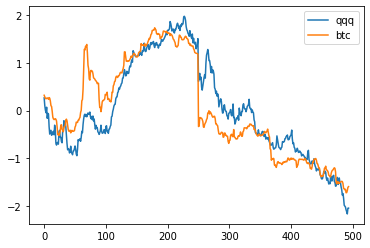

In [6]:
plt.plot(range(len(y1)),y1, label="qqq")
plt.plot(range(len(y2)),y2, label="btc")
plt.legend()

# EDA 

We used the yfinance library, so there wasn’t a need to do much data cleaning for EDA. The downside was that the minute data is limited to only a short period of time for download. 

We looked at BTC and QQQ 5 day price histories to see if they were correlated. They indeed looked correlated. We then normalized the closing prices and performed cross correlation and found BTC to be ahead of QQQ by a number of minutes. We then applied that shift to the price chart.

In [65]:
def max_offset(df1, df2):
#     print(len(df1), len(df2))
    corrs = signal.correlate(df1, df2, mode='full')
    return np.argmax(corrs) - len(df1) + 1, corrs[np.argmax(corrs)]
print(max_offset(y1,y2))

(0, 4657.263934995171)


In [ ]:
global_period = "1d"
global_interval = "1m"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


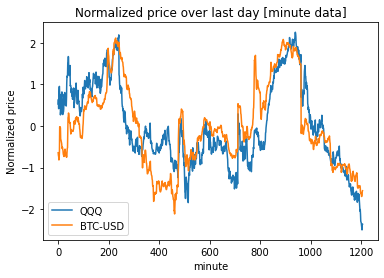

(0, 946.4194546463453)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


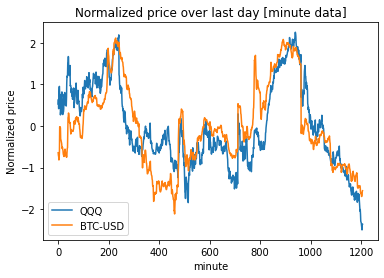

0       0.527238
1       0.638272
2       0.416230
3       0.813154
4       0.935293
          ...   
1201   -2.401316
1202   -2.445731
1203   -2.499304
1204   -2.362458
1205   -2.359680
Name: Close_a, Length: 1206, dtype: float64 0      -0.642669
1      -0.705889
2      -0.737525
3      -0.817434
4      -0.768994
          ...   
1201   -1.695561
1202   -1.693479
1203   -1.648346
1204   -1.573819
1205   -1.556848
Name: Close_b, Length: 1206, dtype: float64
(0, 46216.12912316974, [(0.003312828682910043, 0), (0.010361012023485827, 15), (0.027814768926969637, 30), (0.022865170454147123, 45), (0.008536417029482095, 60), (0.008075500805114115, 75), (0.010451413964966984, 90), (0.019641892144205225, 105), (0.009472031991638732, 120), (0.003665410210419343, 135), (0.008744879699222606, 150), (0.014656485337404171, 165), (0.054979393520618564, 180), (0.0002175704849556731, 195), (0.0007731330676298692, 210), (0.03842025890947595, 225), (0.01989292295326676, 240), (0.0003647251834550391, 255),

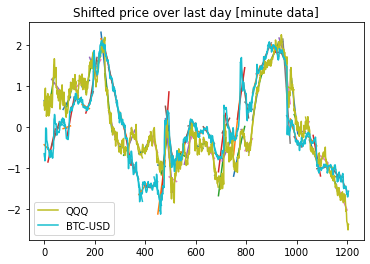

In [67]:
def ticker_offset(str1, str2, silent=False):
    a = yf.download(tickers=str1, period=global_period, interval=global_interval)
    b = yf.download(tickers=str2, period=global_period, interval=global_interval)
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    if not silent:
        plt.plot(range(len(y1)),y1, label=str1)
        plt.plot(range(len(y2)),y2, label=str2)
        plt.legend()
        plt.title("Normalized price over last day [minute data]")
        plt.ylabel("Normalized price")
        plt.xlabel("minute")
        plt.show()
    return max_offset(y1,y2)

def ticker_offset_slope_loss(str1, str2, silent=False):
    a = yf.download(tickers=str1, period=global_period, interval=global_interval)
    b = yf.download(tickers=str2, period=global_period, interval=global_interval)
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    if not silent:
        plt.plot(range(len(y1)),y1, label=str1)
        plt.plot(range(len(y2)),y2, label=str2)
        plt.legend()
        plt.title("Normalized price over last day [minute data]")
        plt.ylabel("Normalized price")
        plt.xlabel("minute")
        plt.show()
    offset = max_offset(y1,y2)[0]
    b["Datetime_shift"] = b.index + pd.Timedelta(minutes=offset)
    shift_df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime_shift", suffixes=["_a","_b"])
    y1 = shift_df['Close_a']
    y2 = shift_df['Close_b']
    y1_original = y1[:]
    y2_original = y2[:]
    
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    print(y1, y2)
    f, ax = plt.subplots()
    def slope_loss(k, s):
        diffs = []
        for i in range(0, len(y1)-k, s):
            xs = np.array(range(i, i+k)).reshape(-1, 1)
            line1 = LinearRegression().fit(xs, y1[i:i+k])
            starty = line1.predict([xs[0]])
            endy = line1.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            reg1 = line1.coef_[0]
            #print("Slope 1 ", reg1)
            line2 = LinearRegression().fit(xs, y2[i:i+k])
            reg2 = line2.coef_[0]
            starty = line2.predict([xs[0]])
            endy = line2.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            #print("Slope 2", reg2)
#             print(type(xs[0]))
            diffs.append((abs(reg1-reg2), list(xs[0])[0]))
#             if i*s < len(y1)-k: 
#                 print(shift_df.iloc[i * s, :])
#         print(np.where(shift_df[shift_df[]))

        #print(diffs)
        return np.sum(diffs), diffs
        
    total_slope_loss, diffs = slope_loss(30, 15)
    if not silent:
        ax.plot(range(len(y1)),y1, label=str1)
        ax.plot(range(len(y2)),y2, label=str2)
        ax.legend()
        ax.set_title("Shifted price over last day [minute data]")
        #ax.ylabel("Normalized price")
        #ax.xlabel("minute")
        #ax.show()
    return offset, total_slope_loss, diffs, y1_original, y2_original
print(ticker_offset("QQQ","BTC-USD"))
print(ticker_offset_slope_loss("QQQ","BTC-USD")[:3])



# Methods

We realized an issue of cross-correlation is that it is influenced a lot by magnitudes. We care a lot more about the slopes.

Our idea: SLOPE LOSS. Use the difference in slopes of the regression line in the loss function. Hyperparameters: stride of slope intervals, length of slope interval.

Our method was centered around performing cross-correlation to see the shift in time that two assets have. So, once we identify a shift in the earlier portion of a day’s data and see the quality of that shift, we can trade off of that for the rest of the day. Some things we could do in the future are vary the level at which we want to trade and such, but for the purposes of this project, we focused on implementing the strategy. In order to evaluate the success of a shift, we used something we came up with to find the loss based on the slopes. That requires some hyperparameters for interval length and stride length, which refer to how long we take a local slope over and stride length refers to how spaced apart start points are. We took numbers that seemed reasonable for this as 25min interval length and 15min stride length [stride length < interval length allows for overlap]. There is a sample graph for this in the slides.

Our trading strategy is as such: wait for the first half of the day until we have enough bars and perform cross correlation to find a the time shift. If such a shift exists, use the shift to trade. If the difference in slopes is greater than a predefined threshold (hyperparameter), and the asset that is leading has the greater slope, then buy. Do the same but in the downwards direction for selling.  

In [146]:
## Early ticker offset does not plot and only uses the 
# first half of the data to find the shift for correlation
from datetime import timedelta
global_interval = "1m"

def early_ticker_offset(str1, str2, start_date):
    start_ts = pd.Timestamp(start_date)
    end_ts = start_ts + timedelta(days=1)
    end_date = str(end_ts).split()[0]
    a = yf.download(tickers=str1, interval=global_interval, start=start_date, end=end_date, progress=False)
    b = yf.download(tickers=str2, interval=global_interval, start=start_date, end=end_date, progress=False)
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    
    ## Use only the first half of the day
    df = df[:len(df)//2]
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1_original = y1[:]
    y2_original = y2[:]
    
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)

    offset = max_offset(y1,y2)[0]
    b["Datetime_shift"] = b.index + pd.Timedelta(minutes=offset)
    shift_df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime_shift", suffixes=["_a","_b"])
    y1 = shift_df['Close_a'][:len(df)//2]
    y2 = shift_df['Close_b'][:len(df)//2]
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    
    def slope_loss(k, s):
        diffs = []
        for i in range(0,len(y1)-k, s):
            xs = np.array(range(i,i+k)).reshape(-1, 1)
            line1 = LinearRegression().fit(xs, y1[i:i+k])
            starty = line1.predict([xs[0]])
            endy = line1.predict([xs[-1]])

            reg1 = line1.coef_[0]
            #print("Slope 1 ", reg1)
            line2 = LinearRegression().fit(xs, y2[i:i+k])
            reg2 = line2.coef_[0]
            starty = line2.predict([xs[0]])
            endy = line2.predict([xs[-1]])

            #print("Slope 2", reg2)
            diffs.append((abs(reg1-reg2), list(xs[0])[0]))
        #print(diffs)
        return np.sum(diffs), diffs
        
    total_slope_loss, diffs = slope_loss(30, 15)
    return offset, total_slope_loss, diffs, y1_original, y2_original

def backtest_one_day(date_str):
    token_diffs = {}
    y1y2_original = {}
    tokens = ["QQQ", "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "ALGO-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "HEX-USD", "AVAX-USD", "DOGE-USD"] # 
    offset_matrix = {}

    for idx1, token1 in enumerate(tokens):
        for idx2, token2 in enumerate(tokens):
            if token1 == token2: 
                continue
            offset, sl, diffs, y1, y2 = early_ticker_offset(token1, token2, date_str)
            pair_symbol = token1 + token2
    #         print(pair_symbol)
            offset_matrix[pair_symbol] = offset
            token_diffs[pair_symbol] = diffs
            y1y2_original[pair_symbol] = (y1, y2)
    #         print(offset_matrix, token_diffs, y1y2_original)
            ##filter for time shifts that make sense and that we can use
            # 15min shift is the limit we picked, and <0 so we can use it to trade
            # if -15<offset<0:
            #     print(token1, token2, offset, "slope loss", sl, diffs)
    
    trading_trigger_threshold = 0.01
    pair_symbols = offset_matrix.keys()
    pnls = []
    pnls_dict = {}
    all_trades = []
    trades_dict = {}
    for pair_symbol in pair_symbols:
        offset = offset_matrix[pair_symbol] 
        diffs = token_diffs[pair_symbol]  
        y1_original, y2_original = y1y2_original[pair_symbol]    
        # print(f"Starting {pair_symbol}")
        pnl = 0
        hold = False
        enter_price = 0
        for i in range(len(diffs)-1):
            if diffs[i+1][0] - diffs[i][0] > trading_trigger_threshold and hold is False: # and diffs[i+1][1]+offset < max_timestamp: # buy
                # pnl -= y2_original[diffs[i+1][1]]
                hold = True
                enter_price = y2_original[diffs[i+1][1]]
                # print(f"Buy @ {y2_original[diffs[i+1][1]]:.4f} | P/L: {pnl}")
            elif diffs[i][0] - diffs[i+1][0] > trading_trigger_threshold and hold is True: # and diffs[i+1][1]+offset < max_timestamp: # sell
                exit_price = y2_original[diffs[i+1][1]]
                result = 100*(exit_price - enter_price) / enter_price
                pnl += result
                all_trades.append(result)
                pair_trades = trades_dict.get(pair_symbol, [])
                pair_trades.append(result)
                trades_dict[pair_symbol] = pair_trades
                hold = False
                # print(f"Sell @ {y2_original[diffs[i+1][1]]:.4f} | P/L: {pnl}")
        if hold:
            exit_price = y2_original[diffs[-1][1]]
            result = 100*(exit_price - enter_price) / enter_price
            pnl += result
            all_trades.append(result)
            pair_trades = trades_dict.get(pair_symbol, [])
            pair_trades.append(result)
            trades_dict[pair_symbol] = pair_trades
            hold = False
            # print(f"Sell @ {y2_original[diffs[-1][1]]:.4f} | P/L: {pnl}")
        pnls.append(pnl)
        pnls_dict[pair_symbol] = pnls_dict.get(pair_symbol, 0) + pnl
        # print(f"Ending {pair_symbol} | P/L %: {pnl:.2f}")
    pair_symbols = offset_matrix.keys()
    return ([*pair_symbols], pnls, pnls_dict, all_trades, trades_dict)
    # plt.figure(figsize=(25, 15))
    # plt.bar(pair_symbols, pnls)
    # plt.title("Our Strategy's P/L Percent for Each Pairing Traded")
    # plt.xlabel("Pairing Traded")
    # plt.ylabel("P/L %")
    # plt.xticks(rotation='vertical')
    # plt.show()




In [119]:
def plot_results(pair_symbols, pnls):
    plt.figure(figsize=(25, 15))
    plt.bar(pair_symbols, pnls)
    plt.title("Our Strategy's P/L Percent for Each Pairing Traded")
    plt.xlabel("Pairing Traded")
    plt.ylabel("P/L %")
    plt.xticks(rotation='vertical')
    plt.show()
    
# symbols, pnls, pnls_dict, all_trades, trades_dict = backtest_one_day("2022-04-29")
# plot_results(symbols, pnls)

In [120]:
def stats(trades, name):
    def sub_stats(trades, name):
        if not len(trades):
            return
        avg = np.mean(trades)
        sd = np.std(trades)
        print(f"{name} | Avg Trade {avg:.2f}% | SD {sd:.2f}%")
    
    wins = trades[trades > 0]
    losses = trades[trades < 0]
    scratch = trades[trades == 0]
    if not len(trades) or len(scratch) == len(trades):
        return
    print(f"{name} | Total P/L % :: {np.sum(trades):.2f}%")
    print(f"Winrate {100*len(wins) / (len(trades) - len(scratch)):.2f}% | {len(trades)} Trades, {len(wins)} Winners, {len(losses)} Losers, {len(scratch)} Breakeven")
    sub_stats(trades, "All Trades")
    sub_stats(wins, "Winners")
    sub_stats(losses, "Losers")
    print(f"Profit Factor: {abs(np.sum(wins) / np.sum(losses))} | Gross Profit: {np.sum(wins):.2f}% | Gross Loss: {np.sum(losses):.2f}%")

In [ ]:
history = {}

In [157]:
#Earliest is 30 days before current day
starting_date = "2022-04-16"
delt = timedelta(days=1)
current_date = pd.Timestamp(starting_date)
for i in range(17):
    cur_date_str = str(current_date).split()[0]
    if current_date.weekday() >= 5:
        #Ignore Saturday and Sunday if QQQ is included
        print(f"Ignoring {cur_date_str}")
        current_date += delt
        continue
    history[cur_date_str] = backtest_one_day(cur_date_str)
    print("Done with",cur_date_str)
    current_date += delt
list(history.keys())


Ignoring 2022-04-16
Ignoring 2022-04-17
Done with 2022-04-18
Done with 2022-04-19
Done with 2022-04-20
Done with 2022-04-21
Done with 2022-04-22
Ignoring 2022-04-23
Ignoring 2022-04-24
Done with 2022-04-25
Done with 2022-04-26
Done with 2022-04-27
Done with 2022-04-28
Done with 2022-04-29
Ignoring 2022-04-30
Ignoring 2022-05-01

1 Failed download:
- QQQ: Data doesn't exist for startDate = 1651464000, endDate = 1651550400

1 Failed download:
- BTC-USD: Data doesn't exist for startDate = 1651464000, endDate = 1651550400


KeyError: 'Datetime'

In [148]:
def get_most_profitable_tickers(n, symbs, pnls):
    inds = np.argsort(-np.array(pnls))
    best = []
    for i in range(n):
        ind = inds[i]
        print(f"{symbs[ind]} | {pnls[ind]:.2f}")
        best.append(symbs[ind])
    return best

def get_least_profitable_tickers(n, symbs, pnls):
    inds = np.argsort(np.array(pnls))
    best = []
    for i in range(n):
        ind = inds[i]
        print(f"{symbs[ind]} | {pnls[ind]:.2f}")
        best.append(symbs[ind])
    return best

## Results

Overall, the trades were mostly positive, winning 52% of the trades made from our aforementioned strategy. Our strategy outperformed BTC heavily during the past 30 days, returning +66% (assuming each trade used 100% of account) while BTC returned -16%. 

Profit factor was 1.1 which is good considering the state of the market overall and that our strategy only went long. We considered a number of indicators that could work and that led to a working strategy. There are additional optimizations we can do, like online updates to cross correlation as data is coming in. Then, we still would want to try out additional hyperparameter tuning and try to limit losses by placing limits on the slope loss for indicators that we consider to be valid.

Moreover, given the downtrend in the current market, it would be better if our strategy could play both long and short. This would just mean adding an additional entry parameter which the inverse of the long entry. Looking at the results by day, we can see a clear positive correlation between BTC's % change that day and our strategy's profitability. Thus, we hypothesize that adding a short entry signal would eliminate this long bias and make our strategy much more profitable in the current market environment. 

Adding on to this, again looking at the results by day, we can see that there are clearly days when the strategy works well (winrate >60%, avg win >> avg loss on those days) and when the strategy performs poorly (40% or less winrate, avg loss >> avg win). In the future, it would be good to add some way to filter the signals so that trades that are less likely to be profitable can be ignored. 

However, when looking at trades by token, we can see that QQQ-crypto pairings did not generate any edge. The best performing pairings were BTC-alt or alt-alt.


## Conclusion

The results of this study were promising. We were able to generate a profit trading only long during a period of time when the markets were extremely bearish. Thus we can reasonably conclude that there does seem to be a significant edge in cross correlation trading. Our pilot study however was very brief and only scratched the surface. There is a lot more research that can and should be done on this topic, including examining different stocks and pairings, adding more and tuning existing hyperparameters, adding more features and indicators that could have predictive power to act as signals or filters to trigger/ignore trades, and more. 



In [178]:
first_index = list(history.keys())[0]
all_pairings = history[first_index][0]
all_trades = []
all_pnls = np.zeros(len(history[first_index][1]))
for _, pnls, pnl_dict, trades, trades_dict in history.values():
    for pair in trades_dict.keys():
        if "XRP-USD" in pair or "ADA-USD" in pair:
            continue
        all_trades += trades_dict[pair]
        all_pnls += np.array(pnl_dict[pair])

all_trades = np.array(all_trades)
stats(all_trades, "All Trades (past 30 days)")
print("----------")
print("----------")

All Trades (past 30 days) | Total P/L % :: 66.01%
Winrate 52.43% | 3878 Trades, 1847 Winners, 1676 Losers, 355 Breakeven
All Trades | Avg Trade 0.02% | SD 0.49%
Winners | Avg Trade 0.34% | SD 0.38%
Losers | Avg Trade -0.33% | SD 0.39%
Profit Factor: 1.1190124798731227 | Gross Profit: 620.64% | Gross Loss: -554.63%
----------
----------


In [180]:
for day in history.keys():
    _, pnls, pnls_dict, trades, trades_dict = history[day]
    trades_that_day = []
    for pair in trades_dict.keys():
        if "XRP-USD" in pair or "ADA-USD" in pair:
            continue
        trades_that_day += trades_dict[pair]
    stats(np.array(trades_that_day), day)
    print("-------------------------")

2022-04-01 | Total P/L % :: 36.58%
Winrate 70.06% | 177 Trades, 117 Winners, 50 Losers, 10 Breakeven
All Trades | Avg Trade 0.21% | SD 0.46%
Winners | Avg Trade 0.42% | SD 0.39%
Losers | Avg Trade -0.25% | SD 0.24%
Profit Factor: 3.9319857573115047 | Gross Profit: 49.05% | Gross Loss: -12.47%
-------------------------
2022-04-04 | Total P/L % :: 2.21%
Winrate 46.84% | 214 Trades, 89 Winners, 101 Losers, 24 Breakeven
All Trades | Avg Trade 0.01% | SD 0.31%
Winners | Avg Trade 0.26% | SD 0.31%
Losers | Avg Trade -0.20% | SD 0.14%
Profit Factor: 1.107483179300907 | Gross Profit: 22.72% | Gross Loss: -20.52%
-------------------------
2022-04-05 | Total P/L % :: -12.40%
Winrate 40.27% | 242 Trades, 91 Winners, 135 Losers, 16 Breakeven
All Trades | Avg Trade -0.05% | SD 0.31%
Winners | Avg Trade 0.19% | SD 0.17%
Losers | Avg Trade -0.22% | SD 0.30%
Profit Factor: 0.5766356079808392 | Gross Profit: 16.88% | Gross Loss: -29.28%
-------------------------
2022-04-06 | Total P/L % :: -12.78%
Winr

In [181]:
"""
2022-04-01 | Total P/L % :: 36.58%
Winrate 70.06% | 177 Trades, 117 Winners, 50 Losers, 10 Breakeven
All Trades | Avg Trade 0.21% | SD 0.46%
Winners | Avg Trade 0.42% | SD 0.39%
Losers | Avg Trade -0.25% | SD 0.24%
Profit Factor: 3.9319857573115047 | Gross Profit: 49.05% | Gross Loss: -12.47%
-------------------------
2022-04-04 | Total P/L % :: 2.21%
Winrate 46.84% | 214 Trades, 89 Winners, 101 Losers, 24 Breakeven
All Trades | Avg Trade 0.01% | SD 0.31%
Winners | Avg Trade 0.26% | SD 0.31%
Losers | Avg Trade -0.20% | SD 0.14%
Profit Factor: 1.107483179300907 | Gross Profit: 22.72% | Gross Loss: -20.52%
-------------------------
2022-04-05 | Total P/L % :: -12.40%
Winrate 40.27% | 242 Trades, 91 Winners, 135 Losers, 16 Breakeven
All Trades | Avg Trade -0.05% | SD 0.31%
Winners | Avg Trade 0.19% | SD 0.17%
Losers | Avg Trade -0.22% | SD 0.30%
Profit Factor: 0.5766356079808392 | Gross Profit: 16.88% | Gross Loss: -29.28%
-------------------------
2022-04-06 | Total P/L % :: -12.78%
Winrate 46.46% | 230 Trades, 92 Winners, 106 Losers, 32 Breakeven
All Trades | Avg Trade -0.06% | SD 0.51%
Winners | Avg Trade 0.38% | SD 0.37%
Losers | Avg Trade -0.45% | SD 0.37%
Profit Factor: 0.7301444979133608 | Gross Profit: 34.58% | Gross Loss: -47.36%
-------------------------
2022-04-07 | Total P/L % :: 21.72%
Winrate 57.43% | 216 Trades, 116 Winners, 86 Losers, 14 Breakeven
All Trades | Avg Trade 0.10% | SD 0.42%
Winners | Avg Trade 0.39% | SD 0.32%
Losers | Avg Trade -0.27% | SD 0.24%
Profit Factor: 1.9458476419543542 | Gross Profit: 44.68% | Gross Loss: -22.96%
-------------------------
2022-04-08 | Total P/L % :: -6.75%
Winrate 44.00% | 222 Trades, 88 Winners, 112 Losers, 22 Breakeven
All Trades | Avg Trade -0.03% | SD 0.47%
Winners | Avg Trade 0.38% | SD 0.31%
Losers | Avg Trade -0.36% | SD 0.34%
Profit Factor: 0.8329436632764522 | Gross Profit: 33.64% | Gross Loss: -40.39%
-------------------------
2022-04-11 | Total P/L % :: -17.54%
Winrate 39.47% | 202 Trades, 75 Winners, 115 Losers, 12 Breakeven
All Trades | Avg Trade -0.09% | SD 0.33%
Winners | Avg Trade 0.21% | SD 0.16%
Losers | Avg Trade -0.29% | SD 0.27%
Profit Factor: 0.4786453794275542 | Gross Profit: 16.10% | Gross Loss: -33.64%
-------------------------
2022-04-12 | Total P/L % :: 47.18%
Winrate 70.83% | 128 Trades, 85 Winners, 35 Losers, 8 Breakeven
All Trades | Avg Trade 0.37% | SD 0.72%
Winners | Avg Trade 0.69% | SD 0.65%
Losers | Avg Trade -0.33% | SD 0.27%
Profit Factor: 5.027999871126033 | Gross Profit: 58.89% | Gross Loss: -11.71%
-------------------------
2022-04-13 | Total P/L % :: 19.47%
Winrate 59.55% | 236 Trades, 131 Winners, 89 Losers, 16 Breakeven
All Trades | Avg Trade 0.08% | SD 0.30%
Winners | Avg Trade 0.29% | SD 0.21%
Losers | Avg Trade -0.20% | SD 0.19%
Profit Factor: 2.074185345093431 | Gross Profit: 37.60% | Gross Loss: -18.13%
-------------------------
2022-04-14 | Total P/L % :: -12.96%
Winrate 43.40% | 232 Trades, 92 Winners, 120 Losers, 20 Breakeven
All Trades | Avg Trade -0.06% | SD 0.35%
Winners | Avg Trade 0.24% | SD 0.23%
Losers | Avg Trade -0.29% | SD 0.26%
Profit Factor: 0.6257156718884684 | Gross Profit: 21.67% | Gross Loss: -34.63%
-------------------------
2022-04-18 | Total P/L % :: -13.45%
Winrate 48.44% | 141 Trades, 62 Winners, 66 Losers, 13 Breakeven
All Trades | Avg Trade -0.10% | SD 0.48%
Winners | Avg Trade 0.24% | SD 0.20%
Losers | Avg Trade -0.43% | SD 0.48%
Profit Factor: 0.5294304496825812 | Gross Profit: 15.13% | Gross Loss: -28.58%
-------------------------
2022-04-19 | Total P/L % :: 6.03%
Winrate 51.83% | 240 Trades, 113 Winners, 105 Losers, 22 Breakeven
All Trades | Avg Trade 0.03% | SD 0.30%
Winners | Avg Trade 0.24% | SD 0.26%
Losers | Avg Trade -0.20% | SD 0.19%
Profit Factor: 1.291437473578219 | Gross Profit: 26.71% | Gross Loss: -20.68%
-------------------------
2022-04-20 | Total P/L % :: 3.90%
Winrate 60.44% | 202 Trades, 110 Winners, 72 Losers, 20 Breakeven
All Trades | Avg Trade 0.02% | SD 0.26%
Winners | Avg Trade 0.18% | SD 0.21%
Losers | Avg Trade -0.22% | SD 0.18%
Profit Factor: 1.2475190836606 | Gross Profit: 19.67% | Gross Loss: -15.77%
-------------------------
2022-04-21 | Total P/L % :: -3.19%
Winrate 47.45% | 214 Trades, 93 Winners, 103 Losers, 18 Breakeven
All Trades | Avg Trade -0.01% | SD 0.39%
Winners | Avg Trade 0.30% | SD 0.26%
Losers | Avg Trade -0.30% | SD 0.28%
Profit Factor: 0.8972416351266185 | Gross Profit: 27.83% | Gross Loss: -31.02%
-------------------------
2022-04-22 | Total P/L % :: -19.15%
Winrate 60.71% | 78 Trades, 34 Winners, 22 Losers, 22 Breakeven
All Trades | Avg Trade -0.25% | SD 0.87%
Winners | Avg Trade 0.26% | SD 0.18%
Losers | Avg Trade -1.27% | SD 1.06%
Profit Factor: 0.31487688849832135 | Gross Profit: 8.80% | Gross Loss: -27.95%
-------------------------
2022-04-25 | Total P/L % :: -57.14%
Winrate 25.42% | 138 Trades, 30 Winners, 88 Losers, 20 Breakeven
All Trades | Avg Trade -0.41% | SD 0.70%
Winners | Avg Trade 0.18% | SD 0.24%
Losers | Avg Trade -0.71% | SD 0.71%
Profit Factor: 0.08545258759985362 | Gross Profit: 5.34% | Gross Loss: -62.48%
-------------------------
2022-04-26 | Total P/L % :: 29.09%
Winrate 60.42% | 208 Trades, 116 Winners, 76 Losers, 16 Breakeven
All Trades | Avg Trade 0.14% | SD 0.62%
Winners | Avg Trade 0.40% | SD 0.70%
Losers | Avg Trade -0.23% | SD 0.24%
Profit Factor: 2.6674711504111763 | Gross Profit: 46.54% | Gross Loss: -17.45%
-------------------------
2022-04-27 | Total P/L % :: 36.95%
Winrate 70.39% | 170 Trades, 107 Winners, 45 Losers, 18 Breakeven
All Trades | Avg Trade 0.22% | SD 0.50%
Winners | Avg Trade 0.47% | SD 0.41%
Losers | Avg Trade -0.31% | SD 0.30%
Profit Factor: 3.6698424122341247 | Gross Profit: 50.79% | Gross Loss: -13.84%
-------------------------
2022-04-28 | Total P/L % :: 32.76%
Winrate 66.89% | 166 Trades, 99 Winners, 49 Losers, 18 Breakeven
All Trades | Avg Trade 0.20% | SD 0.57%
Winners | Avg Trade 0.49% | SD 0.54%
Losers | Avg Trade -0.32% | SD 0.26%
Profit Factor: 3.1162130004983775 | Gross Profit: 48.23% | Gross Loss: -15.48%
-------------------------
2022-04-29 | Total P/L % :: -14.52%
Winrate 51.44% | 222 Trades, 107 Winners, 101 Losers, 14 Breakeven
All Trades | Avg Trade -0.07% | SD 0.55%
Winners | Avg Trade 0.33% | SD 0.24%
Losers | Avg Trade -0.50% | SD 0.51%
Profit Factor: 0.7112476507399474 | Gross Profit: 35.77% | Gross Loss: -50.29%
-------------------------

"""

'\n2022-04-01 | Total P/L % :: 36.58%\nWinrate 70.06% | 177 Trades, 117 Winners, 50 Losers, 10 Breakeven\nAll Trades | Avg Trade 0.21% | SD 0.46%\nWinners | Avg Trade 0.42% | SD 0.39%\nLosers | Avg Trade -0.25% | SD 0.24%\nProfit Factor: 3.9319857573115047 | Gross Profit: 49.05% | Gross Loss: -12.47%\n-------------------------\n2022-04-04 | Total P/L % :: 2.21%\nWinrate 46.84% | 214 Trades, 89 Winners, 101 Losers, 24 Breakeven\nAll Trades | Avg Trade 0.01% | SD 0.31%\nWinners | Avg Trade 0.26% | SD 0.31%\nLosers | Avg Trade -0.20% | SD 0.14%\nProfit Factor: 1.107483179300907 | Gross Profit: 22.72% | Gross Loss: -20.52%\n-------------------------\n2022-04-05 | Total P/L % :: -12.40%\nWinrate 40.27% | 242 Trades, 91 Winners, 135 Losers, 16 Breakeven\nAll Trades | Avg Trade -0.05% | SD 0.31%\nWinners | Avg Trade 0.19% | SD 0.17%\nLosers | Avg Trade -0.22% | SD 0.30%\nProfit Factor: 0.5766356079808392 | Gross Profit: 16.88% | Gross Loss: -29.28%\n-------------------------\n2022-04-06 | Tot

In [160]:
best_pairs = get_most_profitable_tickers(15, all_pairings, all_pnls)


BTC-USDDOGE-USD | 7.37
HEX-USDBNB-USD | 7.15
DOGE-USDBNB-USD | 6.23
LUNA1-USDHEX-USD | 6.04
AVAX-USDADA-USD | 5.85
HEX-USDLUNA1-USD | 5.62
LUNA1-USDBNB-USD | 5.05
ADA-USDAVAX-USD | 4.95
BTC-USDBNB-USD | 4.89
BTC-USDALGO-USD | 4.88
XRP-USDDOGE-USD | 4.66
ETH-USDBNB-USD | 4.43
BNB-USDLUNA1-USD | 4.27
LUNA1-USDAVAX-USD | 3.96
AVAX-USDHEX-USD | 3.86


In [161]:
worst_pairs = get_least_profitable_tickers(15, all_pairings, all_pnls)

ALGO-USDAVAX-USD | -8.45
ADA-USDDOGE-USD | -7.23
ALGO-USDXRP-USD | -7.17
BTC-USDXRP-USD | -6.93
DOGE-USDXRP-USD | -6.79
ADA-USDXRP-USD | -6.67
HEX-USDXRP-USD | -5.33
ALGO-USDADA-USD | -5.20
BNB-USDAVAX-USD | -5.08
BNB-USDADA-USD | -5.04
LUNA1-USDXRP-USD | -5.00
DOGE-USDADA-USD | -4.88
XRP-USDADA-USD | -4.65
AVAX-USDALGO-USD | -4.49
ETH-USDBTC-USD | -4.17


### Our trading strategy is simply comparing ith and (i+1)th slope, if the upwards and downwards diff is greater than a certain threshold, then we buy/sell y2 at the (i+1 timestamp + offset). Given we have already shifted the timestamp and joined both crypto dataframes, I just use y2's y2_original[diffs[i+1][1]] for buy and sell. 

### We paid extra attention to data leackage, i.e. not using future knowledge to trade the current stock


In [162]:
tokens = ["QQQ", "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "ALGO-USD", "HEX-USD", "AVAX-USD", "DOGE-USD"] # 
trades_by_token = {}
for token in tokens:
    for day in history.keys():
        _, pnls, pnls_dict, trades, trades_dict = history[day]
        for key in trades_dict.keys():
            if token in key:
                trades_by_token[token] = trades_by_token.get(token, []) + trades_dict[key]
list(trades_by_token.keys())

    

['QQQ',
 'BTC-USD',
 'ETH-USD',
 'BNB-USD',
 'XRP-USD',
 'LUNA1-USD',
 'ADA-USD',
 'ALGO-USD',
 'HEX-USD',
 'AVAX-USD',
 'DOGE-USD']

In [183]:
for token in ["QQQ", "BTC-USD", "ETH-USD", "BNB-USD", "LUNA1-USD", "ALGO-USD", "HEX-USD", "AVAX-USD", "DOGE-USD"]:
    stats(np.array(trades_by_token[token]), token)
    print("----------------")

QQQ | Total P/L % :: -4.67%
Winrate 50.00% | 257 Trades, 71 Winners, 71 Losers, 115 Breakeven
All Trades | Avg Trade -0.02% | SD 0.37%
Winners | Avg Trade 0.36% | SD 0.24%
Losers | Avg Trade -0.42% | SD 0.35%
Profit Factor: 0.8439297984360714 | Gross Profit: 25.26% | Gross Loss: -29.93%
----------------
BTC-USD | Total P/L % :: 5.92%
Winrate 52.60% | 1016 Trades, 485 Winners, 437 Losers, 94 Breakeven
All Trades | Avg Trade 0.01% | SD 0.52%
Winners | Avg Trade 0.30% | SD 0.40%
Losers | Avg Trade -0.32% | SD 0.50%
Profit Factor: 1.0425461208948326 | Gross Profit: 144.96% | Gross Loss: -139.04%
----------------
ETH-USD | Total P/L % :: 7.28%
Winrate 49.40% | 1166 Trades, 536 Winners, 549 Losers, 81 Breakeven
All Trades | Avg Trade 0.01% | SD 0.41%
Winners | Avg Trade 0.28% | SD 0.33%
Losers | Avg Trade -0.26% | SD 0.33%
Profit Factor: 1.0501686433778488 | Gross Profit: 152.35% | Gross Loss: -145.07%
----------------
BNB-USD | Total P/L % :: 30.02%
Winrate 53.90% | 1245 Trades, 629 Winners

In [184]:
"""
QQQ | Total P/L % :: -4.67%
Winrate 50.00% | 257 Trades, 71 Winners, 71 Losers, 115 Breakeven
All Trades | Avg Trade -0.02% | SD 0.37%
Winners | Avg Trade 0.36% | SD 0.24%
Losers | Avg Trade -0.42% | SD 0.35%
Profit Factor: 0.8439297984360714 | Gross Profit: 25.26% | Gross Loss: -29.93%
----------------
BTC-USD | Total P/L % :: 5.92%
Winrate 52.60% | 1016 Trades, 485 Winners, 437 Losers, 94 Breakeven
All Trades | Avg Trade 0.01% | SD 0.52%
Winners | Avg Trade 0.30% | SD 0.40%
Losers | Avg Trade -0.32% | SD 0.50%
Profit Factor: 1.0425461208948326 | Gross Profit: 144.96% | Gross Loss: -139.04%
----------------
ETH-USD | Total P/L % :: 7.28%
Winrate 49.40% | 1166 Trades, 536 Winners, 549 Losers, 81 Breakeven
All Trades | Avg Trade 0.01% | SD 0.41%
Winners | Avg Trade 0.28% | SD 0.33%
Losers | Avg Trade -0.26% | SD 0.33%
Profit Factor: 1.0501686433778488 | Gross Profit: 152.35% | Gross Loss: -145.07%
----------------
BNB-USD | Total P/L % :: 30.02%
Winrate 53.90% | 1245 Trades, 629 Winners, 538 Losers, 78 Breakeven
All Trades | Avg Trade 0.02% | SD 0.44%
Winners | Avg Trade 0.29% | SD 0.37%
Losers | Avg Trade -0.29% | SD 0.33%
Profit Factor: 1.1945617990587647 | Gross Profit: 184.34% | Gross Loss: -154.32%
----------------
LUNA1-USD | Total P/L % :: 50.68%
Winrate 54.18% | 2358 Trades, 1180 Winners, 998 Losers, 180 Breakeven
All Trades | Avg Trade 0.02% | SD 0.49%
Winners | Avg Trade 0.35% | SD 0.34%
Losers | Avg Trade -0.36% | SD 0.39%
Profit Factor: 1.1393385435967547 | Gross Profit: 414.38% | Gross Loss: -363.70%
----------------
ALGO-USD | Total P/L % :: -9.09%
Winrate 51.15% | 1242 Trades, 577 Winners, 551 Losers, 114 Breakeven
All Trades | Avg Trade -0.01% | SD 0.55%
Winners | Avg Trade 0.34% | SD 0.36%
Losers | Avg Trade -0.38% | SD 0.52%
Profit Factor: 0.9563075557946746 | Gross Profit: 198.91% | Gross Loss: -208.00%
----------------
HEX-USD | Total P/L % :: 33.37%
Winrate 52.29% | 1392 Trades, 684 Winners, 624 Losers, 84 Breakeven
All Trades | Avg Trade 0.02% | SD 0.44%
Winners | Avg Trade 0.31% | SD 0.34%
Losers | Avg Trade -0.29% | SD 0.32%
Profit Factor: 1.184087073294854 | Gross Profit: 214.64% | Gross Loss: -181.27%
----------------
AVAX-USD | Total P/L % :: 6.22%
Winrate 52.57% | 1235 Trades, 593 Winners, 535 Losers, 107 Breakeven
All Trades | Avg Trade 0.01% | SD 0.49%
Winners | Avg Trade 0.34% | SD 0.31%
Losers | Avg Trade -0.37% | SD 0.43%
Profit Factor: 1.0316654781994263 | Gross Profit: 202.75% | Gross Loss: -196.53%
----------------
DOGE-USD | Total P/L % :: -1.66%
Winrate 49.95% | 1125 Trades, 514 Winners, 515 Losers, 96 Breakeven
All Trades | Avg Trade -0.00% | SD 0.63%
Winners | Avg Trade 0.41% | SD 0.51%
Losers | Avg Trade -0.42% | SD 0.51%
Profit Factor: 0.9922566583758843 | Gross Profit: 212.92% | Gross Loss: -214.58%
----------------

"""

'\nQQQ | Total P/L % :: -4.67%\nWinrate 50.00% | 257 Trades, 71 Winners, 71 Losers, 115 Breakeven\nAll Trades | Avg Trade -0.02% | SD 0.37%\nWinners | Avg Trade 0.36% | SD 0.24%\nLosers | Avg Trade -0.42% | SD 0.35%\nProfit Factor: 0.8439297984360714 | Gross Profit: 25.26% | Gross Loss: -29.93%\n----------------\nBTC-USD | Total P/L % :: 5.92%\nWinrate 52.60% | 1016 Trades, 485 Winners, 437 Losers, 94 Breakeven\nAll Trades | Avg Trade 0.01% | SD 0.52%\nWinners | Avg Trade 0.30% | SD 0.40%\nLosers | Avg Trade -0.32% | SD 0.50%\nProfit Factor: 1.0425461208948326 | Gross Profit: 144.96% | Gross Loss: -139.04%\n----------------\nETH-USD | Total P/L % :: 7.28%\nWinrate 49.40% | 1166 Trades, 536 Winners, 549 Losers, 81 Breakeven\nAll Trades | Avg Trade 0.01% | SD 0.41%\nWinners | Avg Trade 0.28% | SD 0.33%\nLosers | Avg Trade -0.26% | SD 0.33%\nProfit Factor: 1.0501686433778488 | Gross Profit: 152.35% | Gross Loss: -145.07%\n----------------\nBNB-USD | Total P/L % :: 30.02%\nWinrate 53.90% |

In [171]:
fixed_trades = []
for day in history.keys():
    _, pnls, pnls_dict, trades, trades_dict = history[day]
    for key in trades_dict.keys():
        if "XRP-USD" in key or "ADA-USD" in key:
            continue
        fixed_trades += trades_dict[key]
stats(np.array(fixed_trades), "Fixed Trades")

Fixed Trades | Total P/L % :: 66.01%
Winrate 52.43% | 3878 Trades, 1847 Winners, 1676 Losers, 355 Breakeven
All Trades | Avg Trade 0.02% | SD 0.49%
Winners | Avg Trade 0.34% | SD 0.38%
Losers | Avg Trade -0.33% | SD 0.39%
Profit Factor: 1.1190124798731227 | Gross Profit: 620.64% | Gross Loss: -554.63%


In [70]:
inds = np.argsort(-np.array(pnls))
symbs = [*pair_symbols]
for i in range(25):
    ind = inds[i]
    print(f"{symbs[ind]} | {pnls[ind]:.2f}")

HEX-USDBNB-USD | 3.02
HEX-USDLUNA1-USD | 2.51
ETH-USDLUNA1-USD | 2.36
AVAX-USDBNB-USD | 2.01
BTC-USDETH-USD | 1.90
ADA-USDLUNA1-USD | 1.86
BTC-USDBNB-USD | 1.70
DOGE-USDETH-USD | 1.62
BNB-USDALGO-USD | 1.61
DOGE-USDADA-USD | 1.58
ALGO-USDBNB-USD | 1.56
XRP-USDETH-USD | 1.55
DOGE-USDALGO-USD | 1.46
ADA-USDHEX-USD | 1.39
XRP-USDADA-USD | 1.30
BNB-USDBTC-USD | 1.28
BTC-USDADA-USD | 1.25
LUNA1-USDETH-USD | 1.18
BNB-USDETH-USD | 1.18
ETH-USDALGO-USD | 1.17
ALGO-USDHEX-USD | 1.12
HEX-USDALGO-USD | 1.11
XRP-USDLUNA1-USD | 1.10
LUNA1-USDADA-USD | 1.05
AVAX-USDALGO-USD | 1.01


In [71]:
inds = np.argsort(np.array(pnls))
symbs = [*pair_symbols]
for i in range(25):
    ind = inds[i]
    print(f"{symbs[ind]} | {pnls[ind]:.2f}")

XRP-USDAVAX-USD | -1.19
QQQDOGE-USD | -1.19
QQQBTC-USD | -1.12
BTC-USDQQQ | -1.05
AVAX-USDXRP-USD | -1.00
XRP-USDQQQ | -0.94
AVAX-USDDOGE-USD | -0.90
ALGO-USDLUNA1-USD | -0.83
BNB-USDXRP-USD | -0.76
ALGO-USDADA-USD | -0.68
AVAX-USDHEX-USD | -0.67
DOGE-USDHEX-USD | -0.67
DOGE-USDQQQ | -0.66
LUNA1-USDDOGE-USD | -0.55
BTC-USDHEX-USD | -0.42
ALGO-USDDOGE-USD | -0.41
ALGO-USDXRP-USD | -0.36
BTC-USDXRP-USD | -0.33
QQQXRP-USD | -0.32
HEX-USDBTC-USD | -0.29
ADA-USDAVAX-USD | -0.27
XRP-USDHEX-USD | -0.26
BNB-USDQQQ | -0.26
BTC-USDDOGE-USD | -0.24
ALGO-USDAVAX-USD | -0.21


In [72]:
trades = np.array(trades)
wins = trades[trades > 0]
losses = trades[trades < 0]
scratch = trades[trades == 0]

In [73]:
def stats(trades, name):
    def sub_stats(trades, name):
        avg = np.mean(trades)
        sd = np.std(trades)
        print(f"{name} | Avg Trade {avg:.2f}% | SD {sd:.2f}%")
    
    wins = trades[trades > 0]
    losses = trades[trades < 0]
    scratch = trades[trades == 0]
    
    print(f"{name} | Total P/L % :: {np.sum(trades):.2f}%")
    print(f"Winrate {100*len(wins) / (len(trades) - len(scratch)):.2f}% | {len(trades)} Trades, {len(wins)} Winners, {len(losses)} Losers, {len(scratch)} Breakeven")
    sub_stats(trades, "All Trades")
    sub_stats(wins, "Winners")
    sub_stats(losses, "Losers")
    print(f"Profit Factor: {abs(np.sum(wins) / np.sum(losses))} | Gross Profit: {np.sum(wins):.2f}% | Gross Loss: {np.sum(losses):.2f}%")

stats(trades, "All Trades")
    
    

All Trades | Total P/L % :: 44.45%
Winrate 56.40% | 437 Trades, 229 Winners, 177 Losers, 31 Breakeven
All Trades | Avg Trade 0.10% | SD 0.52%
Winners | Avg Trade 0.45% | SD 0.44%
Losers | Avg Trade -0.33% | SD 0.27%
Profit Factor: 1.7557963812847739 | Gross Profit: 103.26% | Gross Loss: -58.81%
